<a href="https://colab.research.google.com/github/mae25-create/data_visualization-analysis_practice/blob/main/Expedia_Random_Forest_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Bagging and Boosting to the Expedia Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_clean = pd.read_csv("expedia_clean.csv")

The data preparation is going to be identical to the one we did in the last class (kNN and Decision Trees).

The benefit of ensemble methods like RF and XGB is to improve generalization by reducing variance and bias.

In [ ]:
# Converting the dates to date format (as it was in object format)

df_clean["date_time"] = pd.to_datetime(df_clean["date_time"])
df_clean["srch_ci"] = pd.to_datetime(df_clean["srch_ci"])
df_clean["srch_co"] = pd.to_datetime(df_clean["srch_co"])

In [ ]:
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96534 entries, 0 to 96533
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date_time                 96534 non-null  datetime64[ns]
 1   site_name                 96534 non-null  int64         
 2   posa_continent            96534 non-null  int64         
 3   user_location_country     96534 non-null  object        
 4   user_location_region      96534 non-null  int64         
 5   user_location_city        96534 non-null  int64         
 6   user_id                   96534 non-null  int64         
 7   is_mobile                 96534 non-null  int64         
 8   is_package                96534 non-null  int64         
 9   channel                   96534 non-null  int64         
 10  srch_ci                   96534 non-null  datetime64[ns]
 11  srch_co                   96534 non-null  datetime64[ns]
 12  srch_adults_cnt   

Now, as we mentioned before, the cross validation approach is not suitable, since the data has a time structure. We cannot use future data to predict past data, it doesn't make any sense. So what we are going to do is the following:

We are going to split into 70% training, 15% validation, and 15% testing, based on the time stamp. This means, the first 70% of the data for training, the next 15% for validation, and the last 15% for testing. By doing so, we are training on past data to predict future data, which does make sense.

In [ ]:
df = df_clean.copy()

# Ensure the data is sorted by search date
df = df.sort_values(by="date_time")

# Extract features from srch_ci (Check-in Date)
df["srch_ci_year"] = df["srch_ci"].dt.year
df["srch_ci_month"] = df["srch_ci"].dt.month
df["srch_ci_day"] = df["srch_ci"].dt.day
df["srch_ci_dow"] = df["srch_ci"].dt.dayofweek  # Monday=0, Sunday=6
df["srch_ci_hour"] = df["srch_ci"].dt.hour

# Extract features from srch_co (Check-out Date)
df["srch_co_year"] = df["srch_co"].dt.year
df["srch_co_month"] = df["srch_co"].dt.month
df["srch_co_day"] = df["srch_co"].dt.day
df["srch_co_dow"] = df["srch_co"].dt.dayofweek
df["srch_co_hour"] = df["srch_co"].dt.hour

# Delete time objects
df = df.drop(columns=["srch_ci", "srch_co", "date_time", "time"])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Dealing with categorical variables

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
    "Friday": 4, "Saturday": 5, "Sunday": 6
}
df["day_of_week"] = df["day_of_week"].map(day_map)

categorical_cols = ["user_location_country", "hotel_country"]

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder if you want to inverse transform later

In [ ]:
# Define the split index (70% training, 15% validation, 15% testing)
n_total = len(df)
train_end = int(n_total * 0.70)
val_end = int(n_total * 0.85)

# Split the data
X_train = df.iloc[:train_end].drop("is_booking", axis=1)
y_train = df.iloc[:train_end]["is_booking"]

X_val = df.iloc[train_end:val_end].drop("is_booking", axis=1)
y_val = df.iloc[train_end:val_end]["is_booking"]

X_test = df.iloc[val_end:].drop("is_booking", axis=1)
y_test = df.iloc[val_end:]["is_booking"]

## Bagging and Random Forest

The possible hyperparameters in a Random Forest are:

- **`n_estimators`**: Number of trees in the forest. More trees generally improve performance but increase training time.
- **`max_depth`**: Maximum depth of each tree. Controls model complexity; shallower trees reduce overfitting risk / prevent from overfitting to noise.
- **`min_samples_leaf`**: Minimum number of samples required at a leaf node. Larger values lead to smoother trees and reduce overfitting.
- **`min_samples_split`**: Minimum number of samples required to split an internal node. Higher values prevent overly deep trees.
- **`class_weight`**: Handles class imbalance by assigning weights to classes. `'balanced'` adjusts weights inversely proportional to class frequencies.


✅ min_samples_leaf is a hyperparameter that specifies the minimum number of samples required to be at a leaf node — the end point of a decision path.

We are going to use two approaches here.


1.   We are going to train several models sequentially, using different hyperparameter combinations, and plot the **recall** on both the training and validation sets to visualize how performance evolves and detect overfitting or underfitting.
2.   We will manually implement a grid search by trying all hyperparameter combinations, and we will select the one that gives the highest **recall on the validation set**, without using automated tools like `GridSearchCV`.


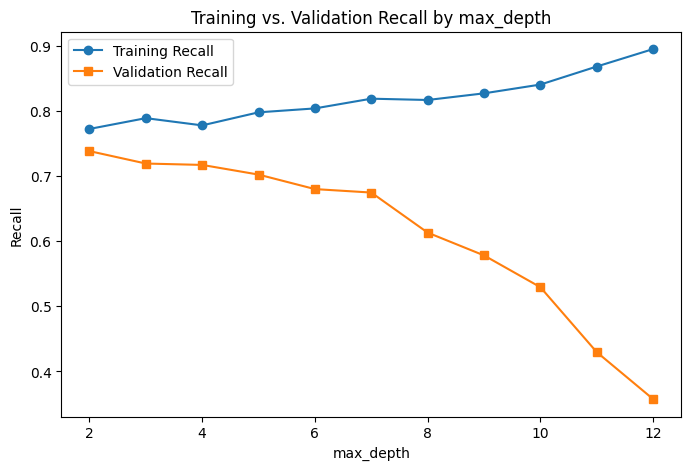

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score

depths = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
recall_train = []
recall_val = []

for d in depths:
    rf = RandomForestClassifier(
        max_depth=d,
        random_state=101,
        class_weight='balanced',
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Training recall
    y_train_pred = rf.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    # Validation recall
    y_val_pred = rf.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, recall_train, label="Training Recall", marker='o')
plt.plot(depths, recall_val, label="Validation Recall", marker='s')
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by max_depth")
plt.legend()
plt.show()

We can see the effect of overfitting. As we increase the depth of the trees, the recall in the training set increases and the recall in the validation set decreases. So, we are going to select `max_depth = 2`.

✅ the highest / best in validation recall, which is 2

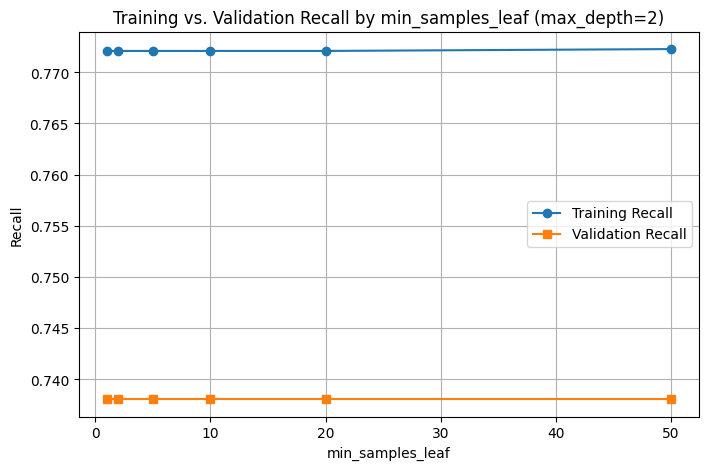

In [ ]:
leaf_sizes = [1, 2, 5, 10, 20, 50]
recall_train = []
recall_val = []

for leaf in leaf_sizes:
    rf = RandomForestClassifier(
        max_depth=2, # We select the one we saw led to the best results
        min_samples_leaf=leaf,
        random_state=101,
        class_weight='balanced',
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Training recall
    y_train_pred = rf.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    # Validation recall
    y_val_pred = rf.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(leaf_sizes, recall_train, label="Training Recall", marker='o')
plt.plot(leaf_sizes, recall_val, label="Validation Recall", marker='s')
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by min_samples_leaf (max_depth=2)")
plt.legend()
plt.grid(True)
plt.show()


Since changing `min_samples_leaf` didn't help, we keep it at `min_samples_leaf = 1`. This was expected because with such a shallow tree (`max_depth = 2`), the number of possible splits is already very limited. Adding further constraints like a larger min_samples_leaf doesn't leave much room for the tree to grow or adapt. It simply restricts learning even more.

With that confirmed, we move on to tuning `n_estimators`, the number of trees in the forest. This can help improve performance by reducing variance through ensemble averaging.

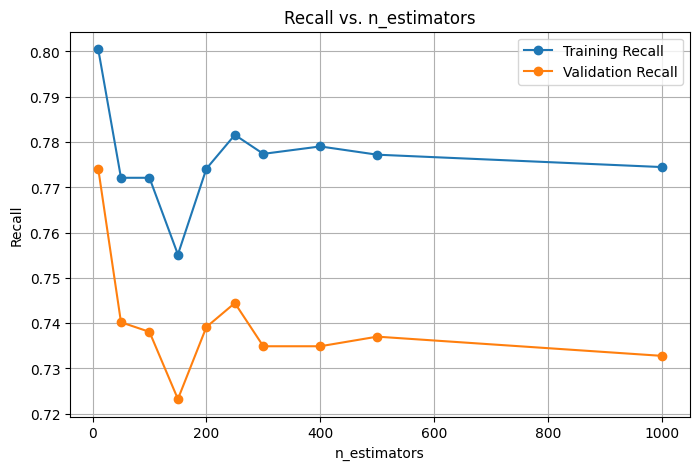

In [ ]:
# Values to test
n_estimators_list = [10, 50, 100, 150, 200, 250, 300, 400, 500, 1000]

train_recalls = []
val_recalls = []

for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n, max_depth=2, min_samples_leaf=1,
                                random_state=101, class_weight = 'balanced')
    rf.fit(X_train, y_train)

    # Predict on training and validation
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    # Compute recall
    train_recalls.append(recall_score(y_train, y_train_pred))
    val_recalls.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_recalls, label='Training Recall', marker='o')
plt.plot(n_estimators_list, val_recalls, label='Validation Recall', marker='o')
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.title("Recall vs. n_estimators")
plt.legend()
plt.grid(True)
plt.show()

We can see that the best Random Forest is with `max_depth = 2`, `min_samples_leaf = 1`, and `n_estimators = 10`.

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Define the model with your best parameters
best_rf = RandomForestClassifier(
    max_depth=2,
    min_samples_leaf=1,
    n_estimators=10,
    random_state=101,
    class_weight='balanced'  # if you used class weights before
)

# Train on the training set
best_rf.fit(X_train, y_train)

# Predict on validation set
y_val_pred = best_rf.predict(X_val)

# Confusion matrix and metrics
cm = confusion_matrix(y_val, y_val_pred)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print("Confusion Matrix:")
print(cm)
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Confusion Matrix:
[[7085 6452]
 [ 213  730]]
Accuracy: 0.540
Precision: 0.102
Recall: 0.774
F1 Score: 0.180


Let's do the second approach: hyperparameters

In [ ]:
# Define hyperparameter grids
max_depth_values = [2, 3, 4, 5]
min_samples_leaf_values = [1, 2, 4]
n_estimators_values = [10, 50, 100]

best_params = {}
best_recall = 0

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        for n_estimators in n_estimators_values:
            # Initialize model
            model = RandomForestClassifier(
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf,
                n_estimators=n_estimators,
                random_state=101,
                class_weight='balanced'  # remember that we had class imbalance
            )
            # Train
            model.fit(X_train, y_train)

            # Predict on validation set
            y_val_pred = model.predict(X_val)

            # Calculate recall
            recall = recall_score(y_val, y_val_pred)

            print(f"max_depth={max_depth}, min_samples_leaf={min_samples_leaf}, n_estimators={n_estimators} -> Recall: {recall:.3f}")

            # Track best
            if recall > best_recall:
                best_recall = recall
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_leaf': min_samples_leaf,
                    'n_estimators': n_estimators
                }

print("\nBest hyperparameters:")
print(best_params)
print(f"Best validation recall: {best_recall:.3f}")


max_depth=2, min_samples_leaf=1, n_estimators=10 -> Recall: 0.774
max_depth=2, min_samples_leaf=1, n_estimators=50 -> Recall: 0.740
max_depth=2, min_samples_leaf=1, n_estimators=100 -> Recall: 0.738
max_depth=2, min_samples_leaf=2, n_estimators=10 -> Recall: 0.774
max_depth=2, min_samples_leaf=2, n_estimators=50 -> Recall: 0.740
max_depth=2, min_samples_leaf=2, n_estimators=100 -> Recall: 0.738
max_depth=2, min_samples_leaf=4, n_estimators=10 -> Recall: 0.774
max_depth=2, min_samples_leaf=4, n_estimators=50 -> Recall: 0.740
max_depth=2, min_samples_leaf=4, n_estimators=100 -> Recall: 0.738
max_depth=3, min_samples_leaf=1, n_estimators=10 -> Recall: 0.663
max_depth=3, min_samples_leaf=1, n_estimators=50 -> Recall: 0.732
max_depth=3, min_samples_leaf=1, n_estimators=100 -> Recall: 0.719
max_depth=3, min_samples_leaf=2, n_estimators=10 -> Recall: 0.663
max_depth=3, min_samples_leaf=2, n_estimators=50 -> Recall: 0.732
max_depth=3, min_samples_leaf=2, n_estimators=100 -> Recall: 0.719
max_d

We can see that, in this case, the best one is the same we had before: **which is（2， 1， 10）and the best reall is 0.774**!

But it doesn't have to be like that.

## Boosting

The main hyperparameters in XGBoost are:

- **`n_estimators`**: Number of boosting rounds (trees). More estimators can improve learning but increase computation and risk of overfitting. **The number of decision trees we use, is the number of estimators**
- **`max_depth`**: Maximum depth of each tree. Controls model complexity; lower values help prevent overfitting.
- **`learning_rate` (or `eta`)**: Step size shrinkage used in each boosting step. Smaller values improve generalization but require more trees.
- **`min_child_weight`**: Minimum sum of instance weight (hessian) needed in a child. Larger values make the algorithm more conservative.
- **`gamma`**: Minimum loss reduction required to make a split. Higher values make the model more conservative.
- **`subsample`**: Fraction of observations to be randomly sampled for each tree. Prevents overfitting (typical values: 0.5 to 1).
- **`colsample_bytree`**: Fraction of features to consider for each tree. Helps reduce correlation between trees.
- **`scale_pos_weight`**: Controls balance of positive and negative weights, useful for imbalanced classes.


Again, we'll use two approaches with `XGBoost`.

In [ ]:
!pip install xgboost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:44:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

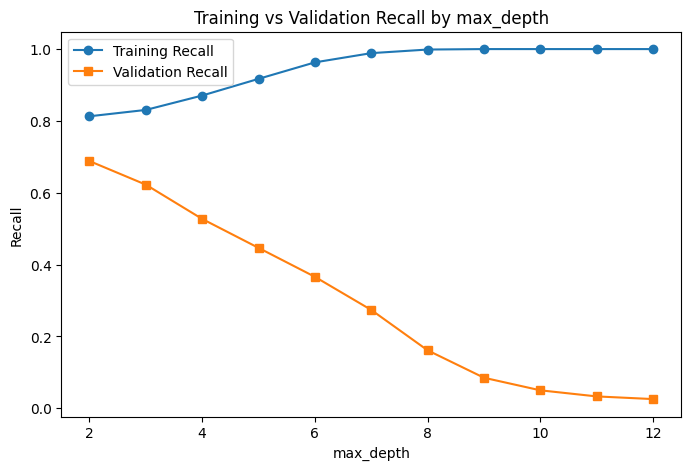

In [ ]:
from xgboost import XGBClassifier

# set best depths (more than 7/8 is big)
depths = list(range(2, 13))
recall_train = []
recall_val = []

for d in depths:
    model = XGBClassifier(
        max_depth=d,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # this is for class imbalance
        n_jobs=-1,
        random_state=101
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    recall_train.append(recall_score(y_train, y_train_pred))
    recall_val.append(recall_score(y_val, y_val_pred))

plt.figure(figsize=(8,5))
plt.plot(depths, recall_train, label='Training Recall', marker='o')
plt.plot(depths, recall_val, label='Validation Recall', marker='s')
plt.xlabel('max_depth')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall by max_depth')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


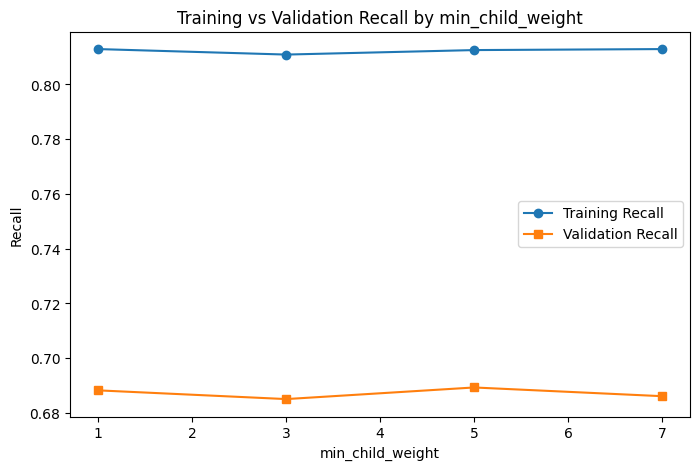

In [ ]:
min_child_weights = [1, 3, 5, 7]
recall_train = []
recall_val = []

for mcw in min_child_weights:
    model = XGBClassifier(
        max_depth=2,
        min_child_weight=mcw,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        n_jobs=-1,
        random_state=101
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    recall_train.append(recall_score(y_train, y_train_pred))
    recall_val.append(recall_score(y_val, y_val_pred))

plt.figure(figsize=(8,5))
plt.plot(min_child_weights, recall_train, label='Training Recall', marker='o')
plt.plot(min_child_weights, recall_val, label='Validation Recall', marker='s')
plt.xlabel('min_child_weight')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall by min_child_weight')
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

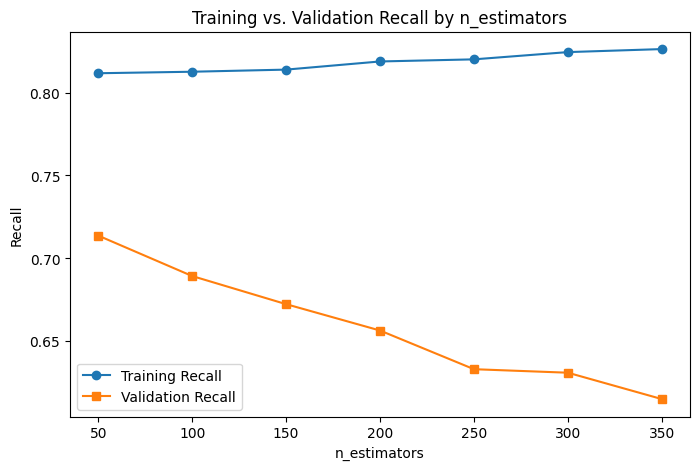

In [ ]:
n_estimators_list = [50, 100, 150, 200, 250, 300, 350]
recall_train = []
recall_val = []

for n in n_estimators_list:
    model = XGBClassifier(
        max_depth=2,
        min_child_weight=5, # based on the previous plot
        n_estimators=n,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=101,
        scale_pos_weight= (y_train == 0).sum() / (y_train == 1).sum()  # optional to handle imbalance
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    y_val_pred = model.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, recall_train, label="Training Recall", marker='o')
plt.plot(n_estimators_list, recall_val, label="Validation Recall", marker='s')
plt.xlabel("n_estimators")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by n_estimators")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

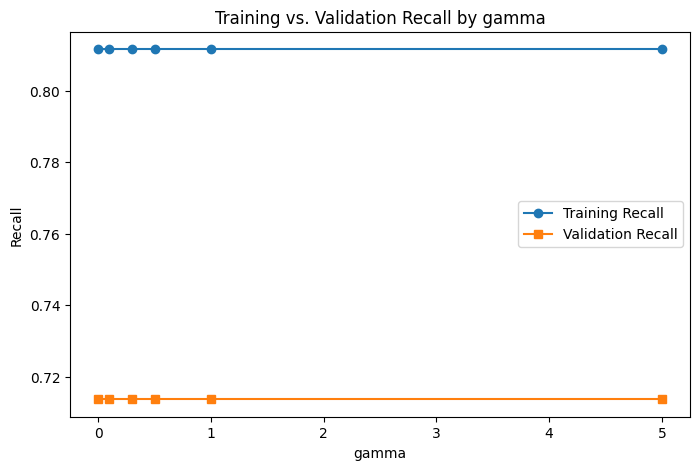

In [ ]:
gammas = [0, 0.1, 0.3, 0.5, 1, 5]
recall_train = []
recall_val = []

for g in gammas:
    model = XGBClassifier(
        max_depth=2,
        min_child_weight=5,
        n_estimators=50, # based on the previous plot
        gamma=g,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=101,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    y_val_pred = model.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(gammas, recall_train, label="Training Recall", marker='o')
plt.plot(gammas, recall_val, label="Validation Recall", marker='s')
plt.xlabel("gamma")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by gamma")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:45:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

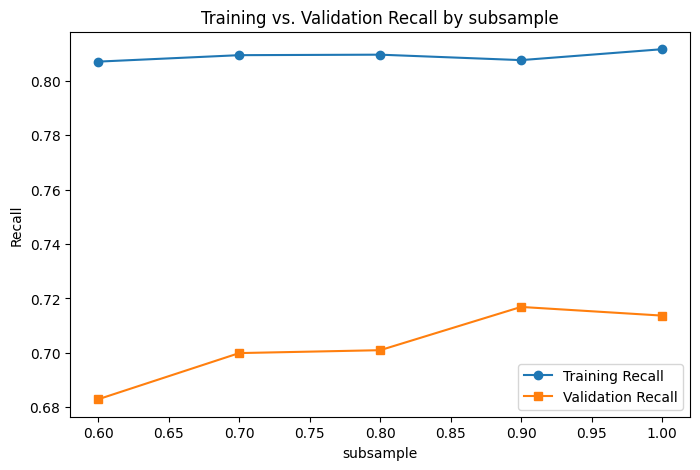

In [ ]:
subsample_values = [0.6, 0.7, 0.8, 0.9, 1.0]
recall_train = []
recall_val = []

for subsample in subsample_values:
    xgb = XGBClassifier(
        max_depth=2,
        n_estimators=50,
        min_child_weight=5,
        gamma=0, # it doesn't change anything, so we keep it simple
        subsample=subsample,
        random_state=101,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    xgb.fit(X_train, y_train)

    # Training recall
    y_train_pred = xgb.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    # Validation recall
    y_val_pred = xgb.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(subsample_values, recall_train, label="Training Recall", marker='o')
plt.plot(subsample_values, recall_val, label="Validation Recall", marker='s')
plt.xlabel("subsample")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by subsample")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

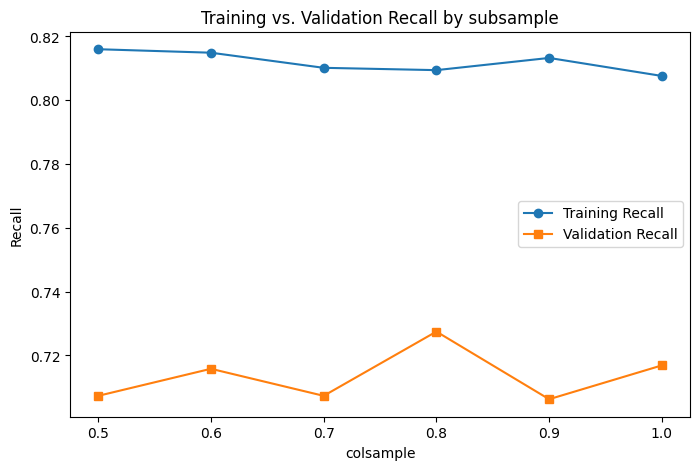

In [ ]:
colsample_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

recall_train = []
recall_val = []

for colsample in colsample_values:
    xgb = XGBClassifier(
        max_depth=2,
        n_estimators=50,
        min_child_weight=5,
        gamma=0,
        subsample=0.9, # based on the previous chart
        colsample_bytree=colsample,
        random_state=101,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    xgb.fit(X_train, y_train)

    # Training recall
    y_train_pred = xgb.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    # Validation recall
    y_val_pred = xgb.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(colsample_values, recall_train, label="Training Recall", marker='o')
plt.plot(colsample_values, recall_val, label="Validation Recall", marker='s')
plt.xlabel("colsample")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by subsample")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

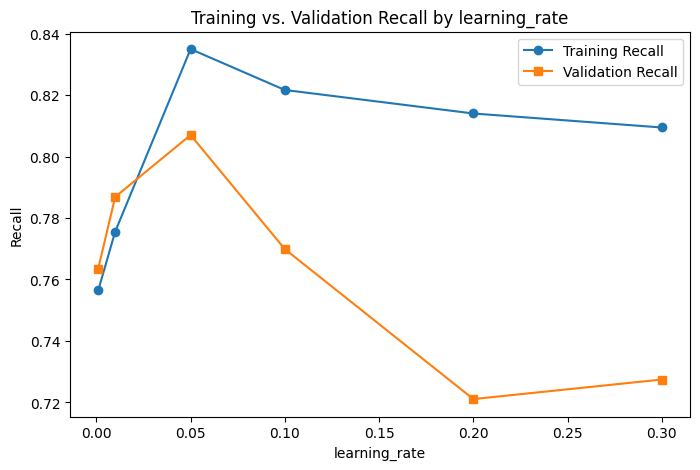

In [ ]:
# test all learning rate over and over again
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

recall_train = []
recall_val = []

for lr in learning_rates:
    xgb = XGBClassifier(
        max_depth=2,
        n_estimators=50,
        min_child_weight=5,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.8,
        learning_rate=lr,
        random_state=101,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    xgb.fit(X_train, y_train)

    # Training recall
    y_train_pred = xgb.predict(X_train)
    recall_train.append(recall_score(y_train, y_train_pred))

    # Validation recall
    y_val_pred = xgb.predict(X_val)
    recall_val.append(recall_score(y_val, y_val_pred))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(learning_rates, recall_train, label="Training Recall", marker='o')
plt.plot(learning_rates, recall_val, label="Validation Recall", marker='s')
plt.xlabel("learning_rate")
plt.ylabel("Recall")
plt.title("Training vs. Validation Recall by learning_rate")
plt.legend()
plt.show()

Now, we'll do the same. We'll get all the metrics in the validation set.

Even 0.05 one in validtion recall is lower than training recall, we still choose the highest 0.05 validation.

Because the highest the score, the lowest variance we can get, which is good.

In [ ]:
# Train the final model
final_xgb = XGBClassifier(
    max_depth=2,
    min_child_weight=5,
    n_estimators=50,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    learning_rate=0.05,
    random_state=101,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)

final_xgb.fit(X_train, y_train)

# Predict on validation set
y_val_pred = final_xgb.predict(X_val)

# Evaluate
print("Validation Performance:")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.2f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.2f}")
print(f"Recall:    {recall_score(y_val, y_val_pred):.2f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance:
Accuracy:  0.54
Precision: 0.10
Recall:    0.81
F1 Score:  0.18

Confusion Matrix:
[[6986 6551]
 [ 182  761]]


Let's do the second approach to finish!

In [ ]:
from itertools import product

# Define grid ranges
param_grid = {
    'max_depth': [2, 3],
    'min_child_weight': [1, 5],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'learning_rate': [0.01, 0.05]
}

# start with only one number (as one combination) to see if there's error
# then, Create all combinations
grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

best_recall = 0
best_params = None

print("Running manual grid search...")

for values in grid:
    params = dict(zip(param_names, values))
    model = XGBClassifier(
        **params,
        random_state=101,
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    recall = recall_score(y_val, preds)

    if recall > best_recall:
        best_recall = recall
        best_params = params

print("\n✅ Best recall on validation set:", round(best_recall, 4))
print("📌 Best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

Running manual grid search...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


✅ Best recall on validation set: 0.8134
📌 Best parameters:
  max_depth: 2
  min_child_weight: 1
  n_estimators: 100
  gamma: 0
  subsample: 0.9
  colsample_bytree: 0.8
  learning_rate: 0.01


We see that, this time, it changed! Let's see the performance!

In [ ]:
# Train the final model
final_xgb = XGBClassifier(
    max_depth=2,
    min_child_weight=1,
    n_estimators=100,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    learning_rate=0.01,
    random_state=101,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
)

final_xgb.fit(X_train, y_train)

# Predict on validation set
y_val_pred = final_xgb.predict(X_val)

# Evaluate
print("Validation Performance:")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.2f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.2f}")
print(f"Recall:    {recall_score(y_val, y_val_pred):.2f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Performance:
Accuracy:  0.52
Precision: 0.10
Recall:    0.81
F1 Score:  0.18

Confusion Matrix:
[[6828 6709]
 [ 176  767]]


In conclusion:

we get 0.8 reall in our final model, we can not use the testing set until the very end

# Visualize the Probability

In Decision Trees, we can explicitly see how the tree is. We can visualize it. We can see which are the variables used in the splits, hence we can see their importance. However, here (and in Random Forests) we can't. We will see a way to extract how important is each feature.


Top 10 Feature Importances:
cnt                      0.576358
stay_length              0.181888
search_lead_time         0.129519
srch_adults_cnt          0.057694
is_package               0.036563
srch_co_year             0.017978
site_name                0.000000
user_location_country    0.000000
posa_continent           0.000000
is_mobile                0.000000
dtype: float32


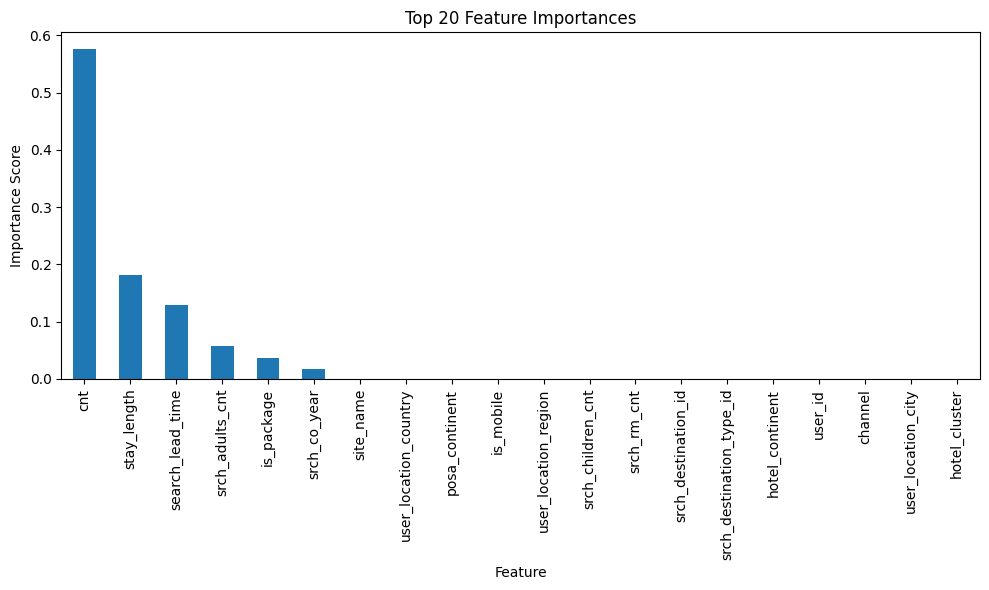

In [ ]:
# Get feature importances
importances = final_xgb.feature_importances_

# If you have feature names
feature_names = X_train.columns

# Create a DataFrame for better visualization
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=False)

# Print top 10 features
print("\nTop 10 Feature Importances:")
print(feat_importances.head(10))

# Plot feature importances
plt.figure(figsize=(10, 6))
feat_importances.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

Remember, we haven't used the testing set at all. The testing set is unseen data. The models we trained have never seen it. Once we determined that this is the best model by taking a look at the validation metrics, we can use the testing set to report its performance on unseen data.

So, we have to retrain it in the train and validation to test it!

In [ ]:
# Combine training and validation data
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

In [ ]:
from xgboost import XGBClassifier

final_xgb_full = XGBClassifier(
    max_depth=2,
    min_child_weight=1,
    n_estimators=100,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.8,
    learning_rate=0.01,
    random_state=101,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(y_full_train == 0).sum() / (y_full_train == 1).sum()
)

final_xgb_full.fit(X_full_train, y_full_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=101, ...)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
y_test_pred = final_xgb_full.predict(X_test)

# Evaluate
print("Test Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.2f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred):.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Test Performance:
Accuracy:  0.54
Precision: 0.11
Recall:    0.83
F1 Score:  0.20

Confusion Matrix:
[[6975 6518]
 [ 170  818]]


Most machine learning classification models—including Decision Trees, Random Forests, k-Nearest Neighbors (kNN), and XGBoost—not only predict the class label (e.g., 0 or 1), but also provide predicted probabilities for each class. These probabilities represent the model's confidence in its prediction.

For example, if the model predicts two columns as "1" with probabilities 0.88 and 0.51, it's obvious that we have more confidence in the first one being a "1". The second is quite "gray".

To access these probabilities in scikit-learn, we use the `.predict_proba()` method instead of `.predict()`.

In [ ]:
# Predict probabilities
y_test_proba = final_xgb_full.predict_proba(X_test)

# Optional: show first 5 predictions and probabilities
results_df = pd.DataFrame({
    "True Label": y_test[:],
    "Predicted Label": y_test_pred[:],
    "Probability Class 0": y_test_proba[:, 0],
    "Probability Class 1": y_test_proba[:, 1],
})
print("\nFirst 5 Predictions with Probabilities:")
results_df.tail(10)


First 5 Predictions with Probabilities:


,True Label,Predicted Label,Probability Class 0,Probability Class 1
20809,0,1,0.427241,0.572759
6594,0,0,0.757040,0.242960
6590,0,0,0.761128,0.238872
20874,0,0,0.540003,0.459997
65719,0,0,0.503254,0.496746
21166,0,0,0.536465,0.463535
88874,0,0,0.763888,0.236112
82840,0,0,0.735440,0.264560
82672,1,1,0.408411,0.591589
21516,1,0,0.517329,0.482671
